## Load pckgs

In [97]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#instalacja y powloki pakietu lifetimes z powloki za pomoca następujacego polecenia
#pip.main(['install', 'lifetimes'])
import lifetimes

# Preprocesing

In [98]:
dataset = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx", sep=";", decimal=",")
dataset.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [99]:
dataset["Amount"]=dataset.Quantity*dataset.UnitPrice
dataset.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


In [100]:
dataset.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
Amount                float64
dtype: object

In [101]:
print(len(dataset))
print(dataset.CustomerID.count())


541909
406829


In [103]:
dataset=dataset.dropna()
dataset=dataset[~dataset['InvoiceNo'].str.contains("C", na=False)]


In [104]:
Orders_cl=pd.DataFrame()
Orders_cl["id"]= dataset.CustomerID
Orders_cl["date"]=dataset.InvoiceDate
Orders_cl["amount"]=dataset.Amount
Orders_cl.date=pd.to_datetime(Orders_cl.date)
print(Orders_cl.head(3))
print(Orders_cl.dtypes)

        id                date  amount
0  17850.0 2010-12-01 08:26:00   15.30
1  17850.0 2010-12-01 08:26:00   20.34
2  17850.0 2010-12-01 08:26:00   22.00
id               float64
date      datetime64[ns]
amount           float64
dtype: object


In [105]:
first_order=Orders_cl.date.min()
last_order=Orders_cl.date.max()
print('Pierwsze zamowienie:',first_order)
print('Ostatnie zamowienie:',last_order)
days=last_order-first_order
print('Ilość dni',days.days)

print('ilość klientów:',Orders_cl.id.nunique())

Pierwsze zamowienie: 2010-12-01 08:26:00
Ostatnie zamowienie: 2011-12-09 12:50:00
Ilość dni 373
ilość klientów: 4339


### Cohort

In [106]:
#Orders_until_feb=Orders_cl[((Orders_cl['date']>'2011-01-01') & (Orders_cl['date']<'2011-04-01'))]
Orders_until_feb=Orders_cl[((Orders_cl['date']<'2011-03-01'))]
#Orders_until_feb= Orders_cl
Orders_until_feb.head(3)

,id,date,amount
0,17850.0,2010-12-01 08:26:00,15.30
1,17850.0,2010-12-01 08:26:00,20.34
2,17850.0,2010-12-01 08:26:00,22.00


In [107]:
customers_filter=Orders_until_feb.id.unique()

In [108]:
customers_filter

array([17850., 13047., 12583., ..., 16518., 17165., 17462.])

In [109]:
Orders_cohort=Orders_cl[Orders_cl['id'].isin(customers_filter)]
print(Orders_cohort.head(3))
print()
print('Pozostała ilośc unikalmnych klientów: ',Orders_cohort.id.nunique() )

        id                date  amount
0  17850.0 2010-12-01 08:26:00   15.30
1  17850.0 2010-12-01 08:26:00   20.34
2  17850.0 2010-12-01 08:26:00   22.00

Pozostała ilośc unikalmnych klientów:  1682


### holdout and train period

In [110]:
split_date='2011-06-09' 
print("Data splitu:", split_date)
period='W' 

Data splitu: 2011-06-09


# Model train

#### Recency - Frequency - Time

In [111]:
RFM = lifetimes.utils.summary_data_from_transaction_data(
    Orders_cohort,
    'id',
    'date',
    observation_period_end=pd.to_datetime(split_date),
    freq=period
)
RFM.head()

,frequency,recency,T
id,,,
12346.0,0.0,0.0,20.0
12347.0,3.0,26.0,26.0
12348.0,2.0,16.0,25.0
12350.0,0.0,0.0,18.0
12352.0,3.0,5.0,16.0


In [112]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(Orders_cohort, 'id', 'date',
                                        calibration_period_end=split_date,
                                        observation_period_end=last_order, freq=period)   
print(summary_cal_holdout.head(3))


         frequency_cal  recency_cal  T_cal  frequency_holdout  \
id                                                              
12346.0            0.0          0.0   20.0                0.0   
12347.0            2.0         17.0   26.0                4.0   
12348.0            2.0         16.0   25.0                1.0   

         duration_holdout  
id                         
12346.0                26  
12347.0                26  
12348.0                26  


In [113]:

weeks_calibration=RFM['T'].max()
print('liczba okresów w próbie uczącej', weeks_calibration)
weeks_holdout=summary_cal_holdout.duration_holdout.max()
print('liczba okresów w próbie testowej:', weeks_holdout)
weeks=weeks_calibration+weeks_holdout
print('liczba wszystkich okresów: ', weeks)


liczba okresów w próbie uczącej 27.0
liczba okresów w próbie testowej: 26
liczba wszystkich okresów:  53.0


# Model Pareto/NBD

In [114]:
from lifetimes import ParetoNBDFitter
paretonbd=ParetoNBDFitter()
paretonbd.fit(RFM['frequency'], RFM['recency'], RFM['T'])



<lifetimes.ParetoNBDFitter: fitted with 1682 subjects, alpha: 9.90, beta: 118.60, r: 0.92, s: 0.00>

In [115]:
#param= [0.1, 0.1, 0.1, 0.1]
#paretonbd.fit(RFM['frequency'], RFM['recency'], RFM['T'], initial_params=param)

In [116]:
paretonbd.params_

OrderedDict([('r', 0.9189949372257769),
             ('alpha', 9.899526937582545),
             ('s', 1.522328007068822e-08),
             ('beta', 118.59837918959386)])

C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\generate_data.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  time_of_death = stats.expon.rvs(scale=1. / mu)


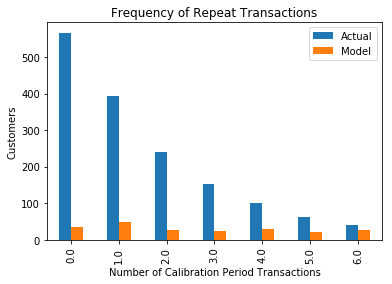

In [117]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(paretonbd)

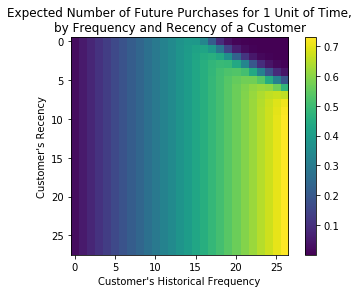

In [118]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(paretonbd)


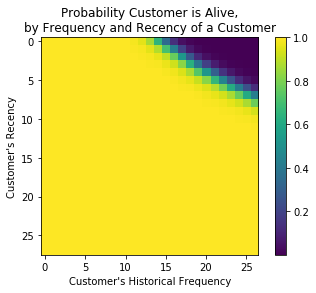

In [119]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [120]:
t = weeks_holdout
RFM['predicted_purchases'] = paretonbd.conditional_expected_number_of_purchases_up_to_time(t, RFM['frequency'], RFM['recency'], RFM['T'])
RFM.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
id,,,,
15311.0,23.0,27.0,27.0,16.853708
15039.0,23.0,26.0,26.0,17.323177
14527.0,24.0,27.0,27.0,17.558324
17841.0,25.0,27.0,27.0,18.262941
14606.0,26.0,27.0,27.0,18.967557


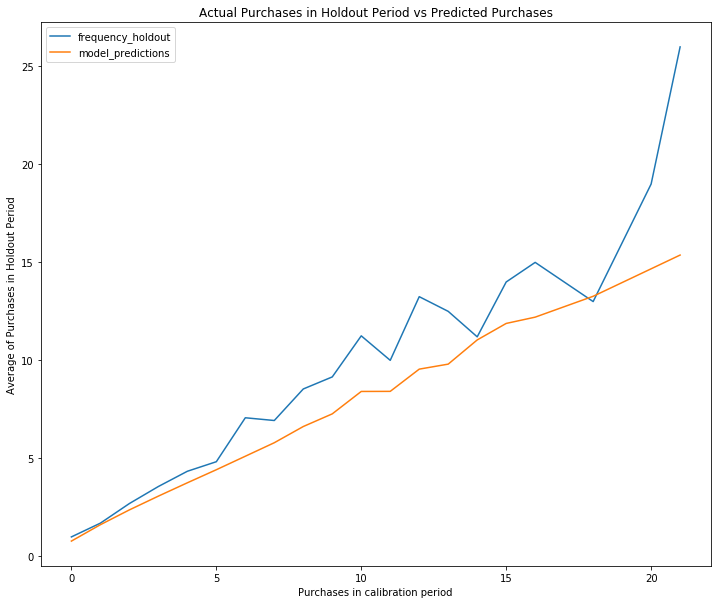

In [121]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

paretonbd.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(paretonbd, summary_cal_holdout, n=20, figsize=(12, 10))

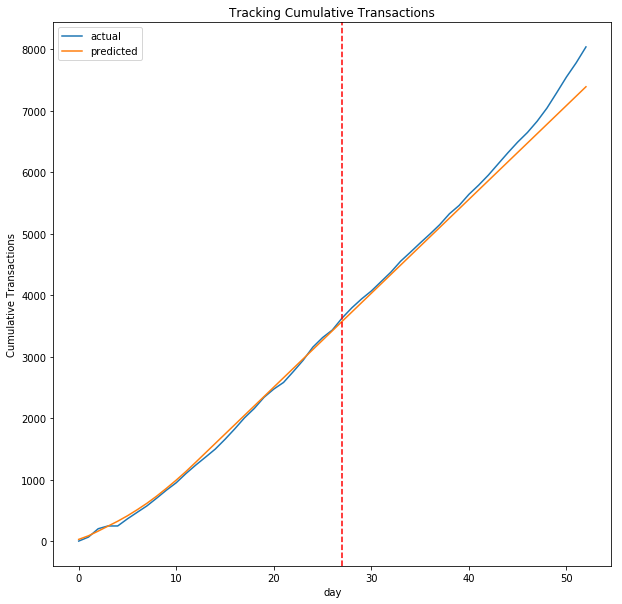

In [122]:
from lifetimes.plotting import plot_cumulative_transactions

plot_cumulative_transactions(paretonbd, Orders_cohort, "date", "id", t=53, t_cal=weeks_calibration, freq=period, figsize=(10, 10))

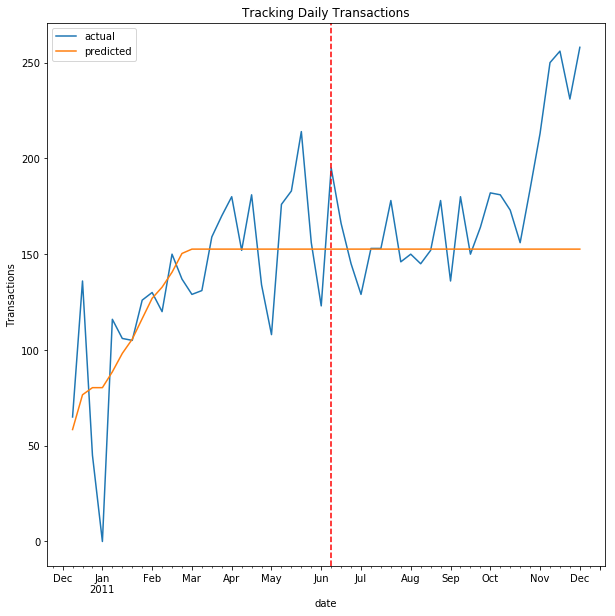

In [123]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(paretonbd, Orders_cohort, "date", "id", t=53, t_cal=weeks_calibration, freq=period, set_index_date=True, figsize=(10, 10))

# Model BG/NBD 

In [124]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter()

bgf.fit(RFM['frequency'], RFM['recency'], RFM['T'])


<lifetimes.BetaGeoFitter: fitted with 1682 subjects, a: 0.00, alpha: 9.90, b: 11.02, r: 0.92>

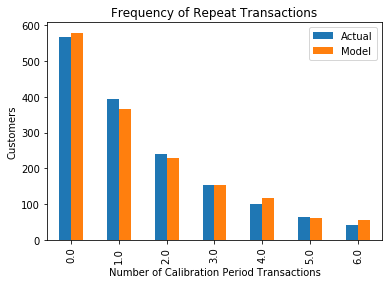

In [125]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

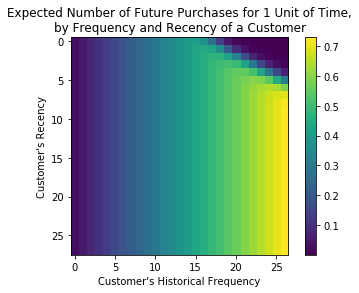

In [126]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)


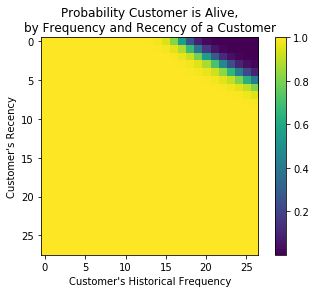

In [127]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [128]:
t = 21
RFM['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, RFM['frequency'], RFM['recency'], RFM['T'])
RFM.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
id,,,,
15311.0,23.0,27.0,27.0,13.612308
15039.0,23.0,26.0,26.0,13.991477
14527.0,24.0,27.0,27.0,14.181407
17841.0,25.0,27.0,27.0,14.750507
14606.0,26.0,27.0,27.0,15.319606


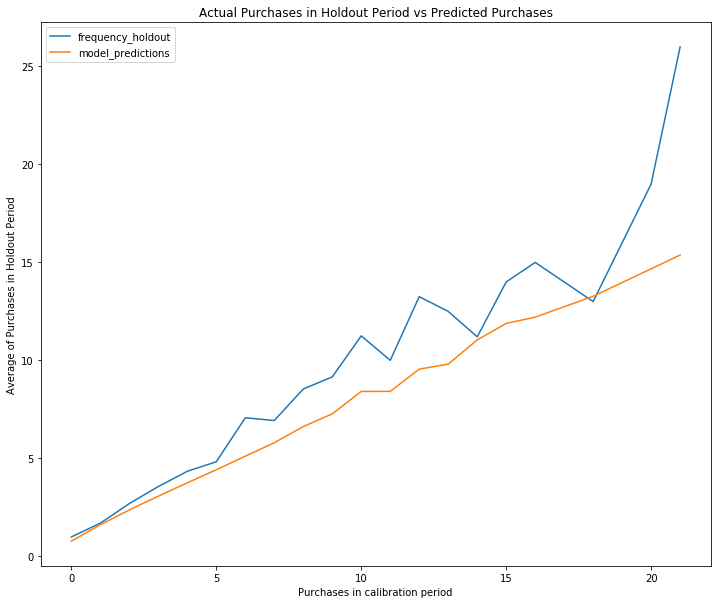

In [129]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=20, figsize=(12, 10)) 

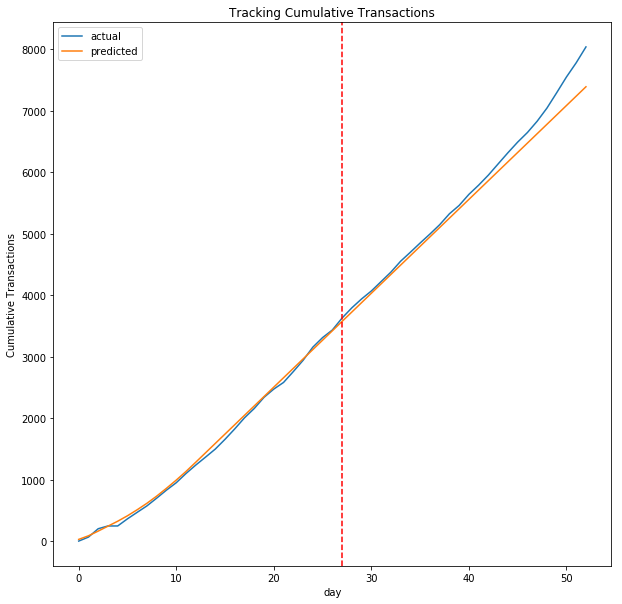

In [130]:
from lifetimes.plotting import plot_cumulative_transactions

plot_cumulative_transactions(bgf, Orders_cohort, "date", "id", t=53, t_cal=weeks_calibration, freq=period, figsize=(10, 10))

In [131]:
from lifetimes.plotting import plot_incremental_transactions

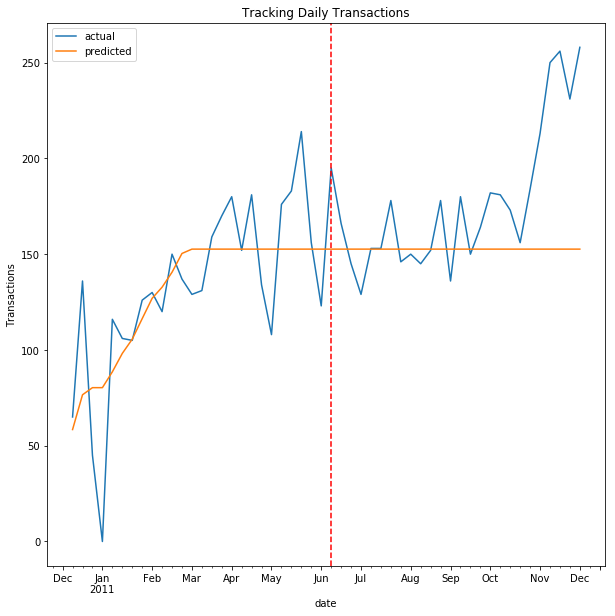

In [132]:
plot_incremental_transactions(bgf, Orders_cohort, "date", "id", t=53, t_cal=weeks_calibration, freq=period, set_index_date=True, figsize=(10, 10))